In [0]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_path='/content/drive/My Drive/prostrate_cancer/cropped/'
coords_path='/content/drive/My Drive/prostrate_cancer/coords.pkl'
labels_path='/content/drive/My Drive/prostrate_cancer/labels.pkl'

In [0]:
images=[]
for i in range(112):
    img=cv2.imread(img_path+"{}.png".format(i))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    images.append(img)

In [0]:
f=open(coords_path,'rb')
coords=pickle.load(f)
f.close()

In [0]:
f=open(labels_path,'rb')
labels=pickle.load(f)
f.close()

In [0]:
##image loading and data loading done
size=25
s=set()
target_images=[]
target_labels=[]

In [0]:
for j in range(112):
    img=images[j]
    if type(coords[j])==type([1,2,3]):
        x,y,_=coords[j][0]
    else:
        x,y,_=coords[j]

    roi=img[x-size:x+size,y-size:y+size]
    target_images.append(roi)

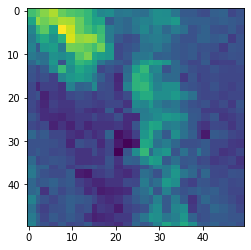

In [0]:
plt.imshow(target_images[0])

In [0]:
len(target_images)
target_images[0].shape

(50, 50)

In [0]:
#data processing
target_images=np.array(target_images)

In [0]:
thresh_value=2
for i in range(len(labels)):
  if labels[i]<thresh_value:
    target_labels.append(0)
  else:
    target_labels.append(1)

In [0]:
pd.Series(target_labels).value_counts()

1    76
0    36
dtype: int64

In [0]:
X=np.array(target_images)
Y=np.array(target_labels)

X=X.reshape(112,50,50,1)

In [0]:
from sklearn.model_selection import train_test_split
xtr,xte,ytr,yte=train_test_split(X,Y,test_size=0.2)

In [0]:
xtr=xtr/255.0
xte=xte/255.0
from keras.utils import to_categorical
ytr=to_categorical(ytr)
yte=to_categorical(yte)

In [0]:
ytr.shape,xtr.shape

((89, 2), (89, 50, 50, 1))

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,MaxPool2D

model=Sequential()

model.add(Conv2D(64,input_shape=(2*size,2*size,1),kernel_size=1,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=1))

"""model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))"""

model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=1))

#model.add(Conv2D(256,kernel_size=1,activation='tanh'))             ##new layer

model.add(Flatten())
model.add(Dense(20,activation='relu'))
#model.add(Dense(10,activation='relu'))
#model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(xtr,ytr,epochs=10,validation_data=(xte,yte))

Train on 89 samples, validate on 23 samples
Epoch 1/10


In [0]:
from keras.models import load_model
model.save('/content/drive/My Drive/prostrate_cancer/model.h5')